### Namaster Example 6: Pure E and B

This sample script showcases the computation of power spectra using the pure-E and B approach.

Warning

If you have HEALPix UNSEEN values in your map, set those pixels to zero in both the mask and map in order to use B-mode purification.

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10


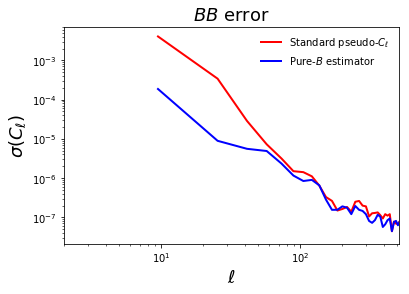

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

# This script describes the computation of polarized power spectra using the
# pure-E and B approach

# We'll run this many simulations
nsim = 10
# HEALPix map resolution
nside = 256

# Let us first create a square mask:
msk = np.zeros(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
msk[np.where((th < 2.63) & (th > 1.86) &
             (ph > -np.pi / 4) & (ph < np.pi / 4))[0]] = 1.

# Now we apodize the mask. The pure-B formalism requires the mask to be
# differentiable along the edges. The 'C1' and 'C2' apodization types
# supported by mask_apodization achieve this.
msk_apo = nmt.mask_apodization(msk, 10.0, apotype='C1')

# Select a binning scheme
##b = nmt.NmtBin.from_nside_linear(nside, 16)
b= nmt.NmtBin(nside,nlb=16)


leff = b.get_effective_ells()

# Read power spectrum and provide function to generate simulated skies
l, cltt, clee, clbb, clte = np.loadtxt('cls.txt', unpack=True)


def get_fields():
    mp_t, mp_q, mp_u = hp.synfast([cltt, clee, clbb, clte],
                                  nside=nside, new=True, verbose=False)
    # This creates a spin-2 field without purifying either E or B
    f2_np = nmt.NmtField(msk_apo, [mp_q, mp_u])
    # This creates a spin-2 field with both pure E and B.
    f2_yp = nmt.NmtField(msk_apo, [mp_q, mp_u], purify_e=True, purify_b=True)
    # Note that generally it's not a good idea to purify both,
    # since you'll lose sensitivity on E
    return f2_np, f2_yp


# We initialize two workspaces for the non-pure and pure fields:
f2np0, f2yp0 = get_fields()
w_np = nmt.NmtWorkspace()
w_np.compute_coupling_matrix(f2np0, f2np0, b)
w_yp = nmt.NmtWorkspace()
w_yp.compute_coupling_matrix(f2yp0, f2yp0, b)


# This wraps up the two steps needed to compute the power spectrum
# once the workspace has been initialized
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled


# We now iterate over several simulations, computing the
# power spectrum for each of them
data_np = []
data_yp = []
for i in np.arange(nsim):
    print(i, nsim)
    fnp, fyp = get_fields()
    data_np.append(compute_master(fnp, fnp, w_np))
    data_yp.append(compute_master(fyp, fyp, w_yp))
data_np = np.array(data_np)
data_yp = np.array(data_yp)
clnp_mean = np.mean(data_np, axis=0)
clnp_std = np.std(data_np, axis=0)
clyp_mean = np.mean(data_yp, axis=0)
clyp_std = np.std(data_yp, axis=0)

# Now we plot the results
plt.figure()
plt.title('$BB$ error', fontsize=18)
plt.plot(leff, clnp_std[3], 'r-', lw=2, label='Standard pseudo-$C_\\ell$')
plt.plot(leff, clyp_std[3], 'b-', lw=2, label='Pure-$B$ estimator')
plt.xlim([2, 512])
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$\\sigma(C_\\ell)$', fontsize=18)
plt.legend(loc='upper right', frameon=False)
plt.loglog()
plt.show()
